In [13]:
import energyflow as ef
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch_geometric.utils import scatter

In [43]:
data = ef.zjets_delphes.load("Herwig", num_data=500000, pad=True, cache_dir='/Users/antoine/Developer/Heidelberg/high-dim-unfolding/data/zplusjet/',
                                       source='zenodo', which='all',
                                       include_keys=None, exclude_keys=None)

In [44]:
def handle_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

In [45]:
det_jets = data['sim_jets'][:, np.newaxis, :]
det_particles = data['sim_particles']
det_particles[..., 0] = det_particles[..., 0] * 100
det_particles[..., 1:3] = det_particles[..., 1:3] + det_jets[..., 1:3]
det_particles[..., 2] = handle_angle(det_particles[..., 2])
det_mults = data['sim_mults']
gen_jets = data['gen_jets'][:, np.newaxis, :]
gen_particles = data['gen_particles']
gen_particles[..., 0] = gen_particles[..., 0] * 100
gen_particles[...,1:3] = gen_particles[..., 1:3] + gen_jets[..., 1:3]
gen_particles[..., 2] = handle_angle(gen_particles[..., 2])
gen_mults = data['gen_mults']
gen_tau1s = data['gen_widths']
det_tau1s = data['sim_widths']
gen_tau2s = data['gen_tau2s']
det_tau2s = data['sim_tau2s']

In [46]:
def jetmomenta_to_fourmomenta(jetmomenta):
    pt, eta, phi, mass = jetmomenta.T

    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    E = np.sqrt(mass**2 + px**2 + py**2 + pz**2)

    fourmomenta = np.stack((E, px, py, pz), axis=-1)
    return fourmomenta

In [47]:
pid_to_mass = {
    0.0: 0.0,      # Photon (PID 22)
    0.1: 0.139570, # π⁺ (PID 211)
    0.2: 0.139570, # π⁻ (PID -211)
    0.3: 0.497614, # K⁰_L (PID 130)
    0.4: 0.000511, # Electron (PID 11)
    0.5: 0.000511, # Positron (PID -11)
    0.6: 0.105658, # μ⁺ (PID 13)
    0.7: 0.105658, # μ⁻ (PID -13)
    0.8: 0.493677, # K⁺ (PID 321)
    0.9: 0.493677, # K⁻ (PID -321)
    1.0: 0.938272, # Proton (PID 2212)
    1.1: 0.938272, # Antiproton (PID -2212)
    1.2: 0.939565, # Neutron (PID 2112)
    1.3: 0.939565  # Antineutron (PID -2112)
}

In [48]:
parts = gen_particles[0, :gen_mults[0], :]
for i in range(len(parts)):
    parts[i, 3] = pid_to_mass[parts[i, 3]]

In [49]:
parts = jetmomenta_to_fourmomenta(parts)

In [50]:
parts.sum(axis=0)

array([ 267.07835451, -237.05442579,  -50.3707704 ,  107.94125556])

In [51]:
jetmomenta_to_fourmomenta(gen_jets[0])

array([[ 266.88193733, -237.05443553,  -50.37073848,  107.39541266]])

In [21]:
gen_tau1s[0], gen_tau2s[0], gen_tau2s[0] / gen_tau1s[0]

(np.float64(0.18464174948632878),
 np.float64(0.08554272645141206),
 np.float64(0.4632902725921464))

In [22]:
parts

array([[ 2.45296510e+01, -2.21848452e+01, -3.10316412e+00,
         9.98313976e+00],
       [ 5.94747141e-01, -5.54931144e-01, -1.09646970e-01,
         1.19471100e-01],
       [ 1.36069993e+00, -8.07745289e-01, -1.08980718e-01,
         5.53913981e-01],
       [ 3.29124132e+00, -2.95312137e+00, -9.99268680e-01,
         1.04562227e+00],
       [ 1.50430601e+00, -1.30248105e+00, -6.85709475e-02,
         7.36408808e-01],
       [ 1.07121325e+01, -9.44700083e+00, -2.77333179e+00,
         4.21818781e+00],
       [ 1.13992476e+01, -9.43471126e+00, -5.21364717e+00,
         3.70506048e+00],
       [ 7.18960377e+00, -6.16731547e+00, -2.02159703e+00,
         3.05289174e+00],
       [ 2.46354028e+00, -2.16369543e+00, -6.57188656e-01,
         9.77525380e-01],
       [ 2.21394941e-01, -1.86112224e-01, -3.10367461e-02,
         1.15821762e-01],
       [ 4.63292456e+00, -3.68594602e+00, -2.39900446e+00,
         1.45020334e+00],
       [ 1.36924464e+00, -1.10316548e+00, -5.64902921e-01,
      

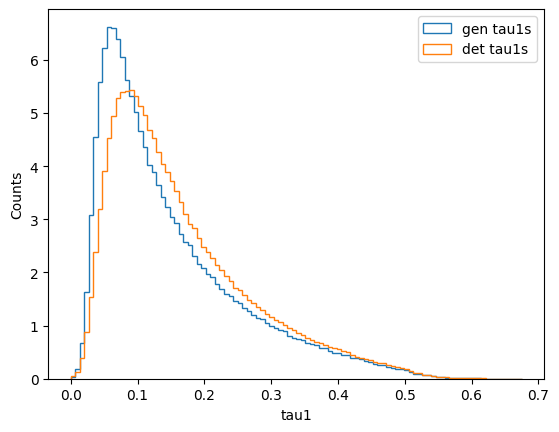

In [23]:

_, bins = np.histogram(gen_tau1s, bins=100)
plt.hist(gen_tau1s, bins=bins, label='gen tau1s', histtype='step', density=True)
plt.hist(det_tau1s, bins=bins, label='det tau1s', histtype='step', density=True)
plt.xlabel('tau1')
plt.ylabel('Counts')
plt.legend()
plt.show()

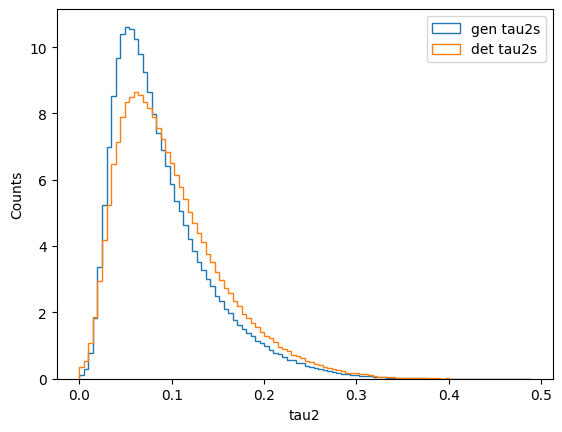

In [24]:

_, bins = np.histogram(gen_tau2s, bins=100)
plt.hist(gen_tau2s, bins=bins, label='gen tau2s', histtype='step', density=True)
plt.hist(det_tau2s, bins=bins, label='det tau2s', histtype='step', density=True)
plt.xlabel('tau2')
plt.ylabel('Counts')
plt.legend()
plt.show()

/var/folders/cz/0p99_3sd5vn72h_y01jd523c0000gn/T/ipykernel_84901/2129174857.py:1: RuntimeWarning: invalid value encountered in divide
  gen_t21 = np.where(gen_tau1s < 0.001, 0, gen_tau2s / gen_tau1s)
/var/folders/cz/0p99_3sd5vn72h_y01jd523c0000gn/T/ipykernel_84901/2129174857.py:2: RuntimeWarning: invalid value encountered in divide
  det_t21 = np.where(det_tau1s < 0.001, 0, det_tau2s / det_tau1s)


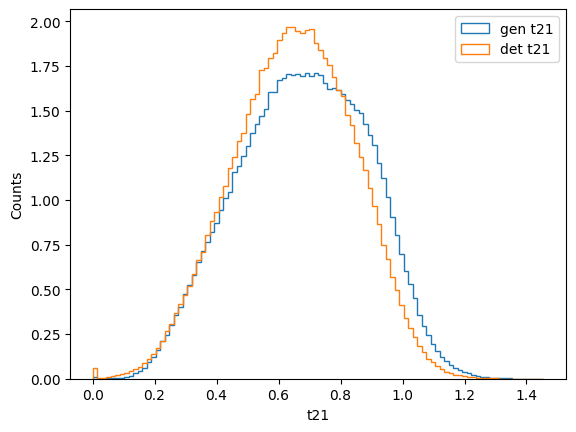

In [25]:
gen_t21 = np.where(gen_tau1s < 0.001, 0, gen_tau2s / gen_tau1s)
det_t21 = np.where(det_tau1s < 0.001, 0, det_tau2s / det_tau1s)
_, bins = np.histogram(gen_t21, bins=100)
plt.hist(gen_t21, bins=bins, label='gen t21', histtype='step', density=True)
plt.hist(det_t21, bins=bins, label='det t21', histtype='step', density=True)
plt.xlabel('t21')
plt.ylabel('Counts')
plt.legend()
plt.show()

In [5]:
det_mask = np.arange(det_particles.shape[1])[None, :] < det_mults[:, None]
gen_mask = np.arange(gen_particles.shape[1])[None, :] < gen_mults[:, None]

In [6]:
def nth_largest_pt_mask(particles, n):
    """
    Returns a boolean mask to extract the particle with the n-th largest pt on axis 1.
    
    Args:
    particles: numpy array of shape (num_events, num_particles, 4)
    n: int, the rank of pt to select (1 for largest, 2 for second largest, etc.)
    
    Returns:
    mask: boolean numpy array of the same shape as particles
    """
    pt = particles[..., 0]
    rank = pt.argsort(axis=1)
    nth_largest_indices = rank[:, -n]
    mask = np.zeros_like(pt, dtype=bool)
    mask[np.arange(len(mask)), nth_largest_indices] = True
    return mask

In [7]:
det_jets[..., 2] = handle_angle(det_jets[..., 2])
det_jets = det_jets.squeeze()
flattened_det_particles = det_particles[det_mask]
gen_jets[..., 2] = handle_angle(gen_jets[..., 2])
gen_jets = gen_jets.squeeze()
flattened_gen_particles = gen_particles[gen_mask]

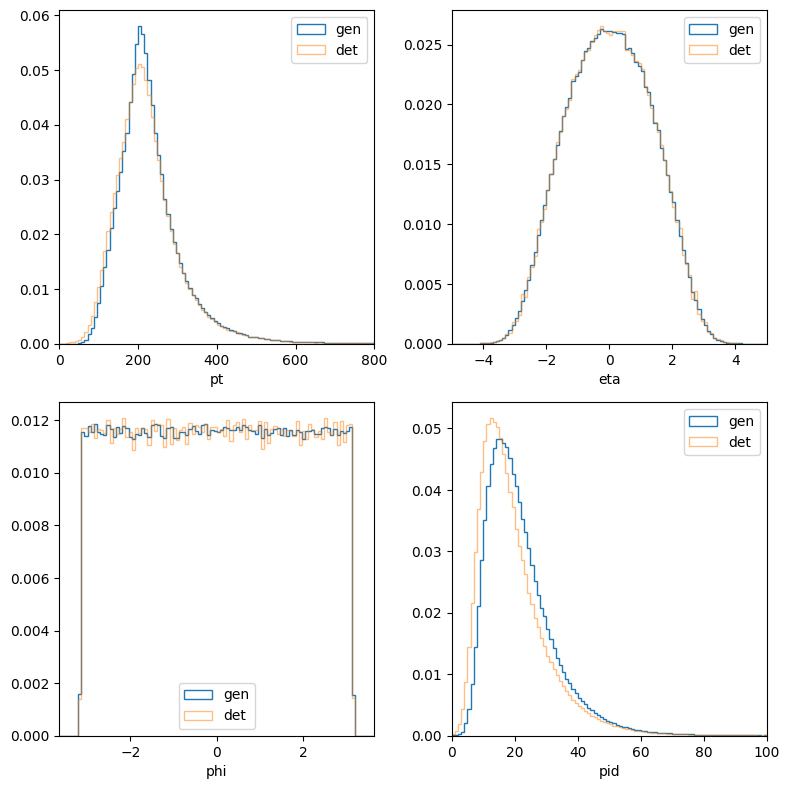

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
labels = ['pt', 'eta', 'phi', 'pid']
x_limits = [(0, 800), (-5, 5), (-np.pi - 0.5, np.pi + 0.5), (0, 100)]
for i, ax in enumerate(ax.flatten()):
    
    gen_hist, bins = np.histogram(gen_jets[:, i], bins=100, range=x_limits[i])
    det_hist, _ = np.histogram(det_jets[:, i], bins=bins)

    gen_hist = gen_hist / len(gen_jets)
    det_hist = det_hist / len(det_jets)
    
    ax.hist(bins[:-1], bins=bins, weights=gen_hist, label='gen', histtype='step')
    ax.hist(bins[:-1], bins=bins, weights=det_hist, label='det', histtype='step', alpha=0.5)
    ax.set_xlabel(labels[i])
    ax.set_xlim(x_limits[i])
    ax.legend()
fig.tight_layout()
plt.show()

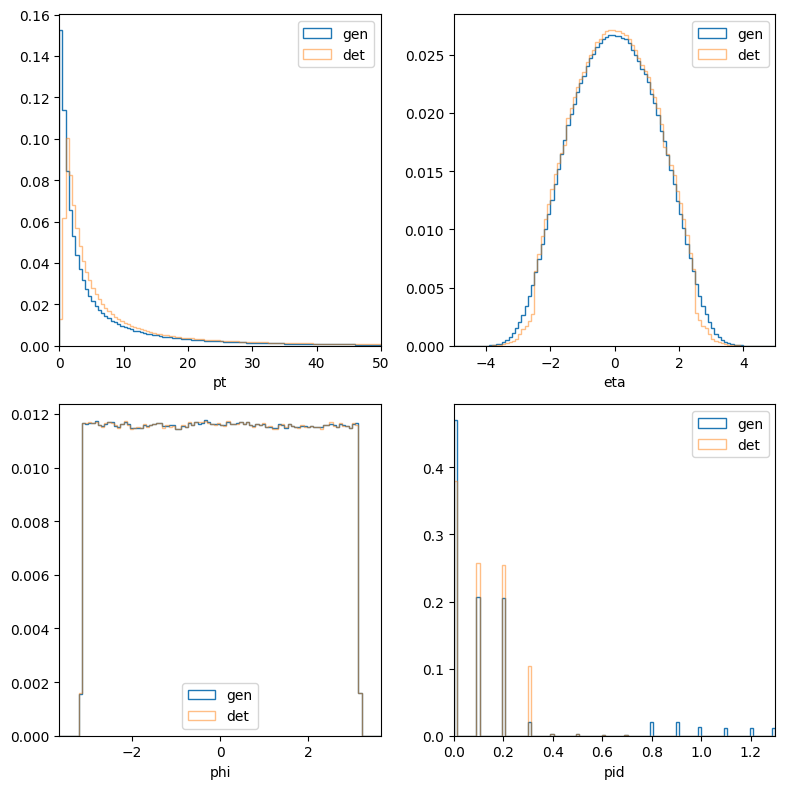

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
labels = ['pt', 'eta', 'phi', 'pid']
x_limits = [(0, 50), (-5, 5), (-np.pi - 0.5, np.pi + 0.5), (0, 1.3)]
for i, ax in enumerate(ax.flatten()):
    
    gen_hist, bins = np.histogram(flattened_gen_particles[:, i], bins=100, range=x_limits[i])
    det_hist, _ = np.histogram(flattened_det_particles[:, i], bins=bins)
    
    gen_hist = gen_hist / len(flattened_gen_particles)
    det_hist = det_hist / len(flattened_det_particles)
    
    ax.hist(bins[:-1], bins=bins, weights=gen_hist, label='gen', histtype='step')
    ax.hist(bins[:-1], bins=bins, weights=det_hist, label='det', histtype='step', alpha=0.5)
    ax.set_xlabel(labels[i])
    ax.set_xlim(x_limits[i])
    ax.legend()
fig.tight_layout()
plt.show()

In [10]:
MASS = 0.1
flattened_det_particles[..., -1] = MASS
flattened_gen_particles[..., -1] = MASS

In [12]:
det_fourmomenta = jetmomenta_to_fourmomenta(flattened_det_particles)
det_jets_fourmomenta = jetmomenta_to_fourmomenta(det_jets)
gen_fourmomenta = jetmomenta_to_fourmomenta(flattened_gen_particles)
gen_jets_fourmomenta = jetmomenta_to_fourmomenta(gen_jets)

In [13]:
def get_batch_from_ptr(ptr):
    return torch.arange(len(ptr) - 1, device=ptr.device).repeat_interleave(
        ptr[1:] - ptr[:-1],
    )

In [14]:
gen_ptr = np.insert(np.cumsum(gen_mults), 0, 0)
gen_batch = get_batch_from_ptr(torch.tensor(gen_ptr))
det_ptr = np.insert(np.cumsum(det_mults), 0, 0)
det_batch = get_batch_from_ptr(torch.tensor(det_ptr))

In [15]:
agg_gen_fourmomenta = scatter(torch.tensor(gen_fourmomenta), index=gen_batch, dim=0, reduce="sum")
agg_det_fourmomenta = scatter(torch.tensor(det_fourmomenta), index=det_batch, dim=0, reduce='sum')

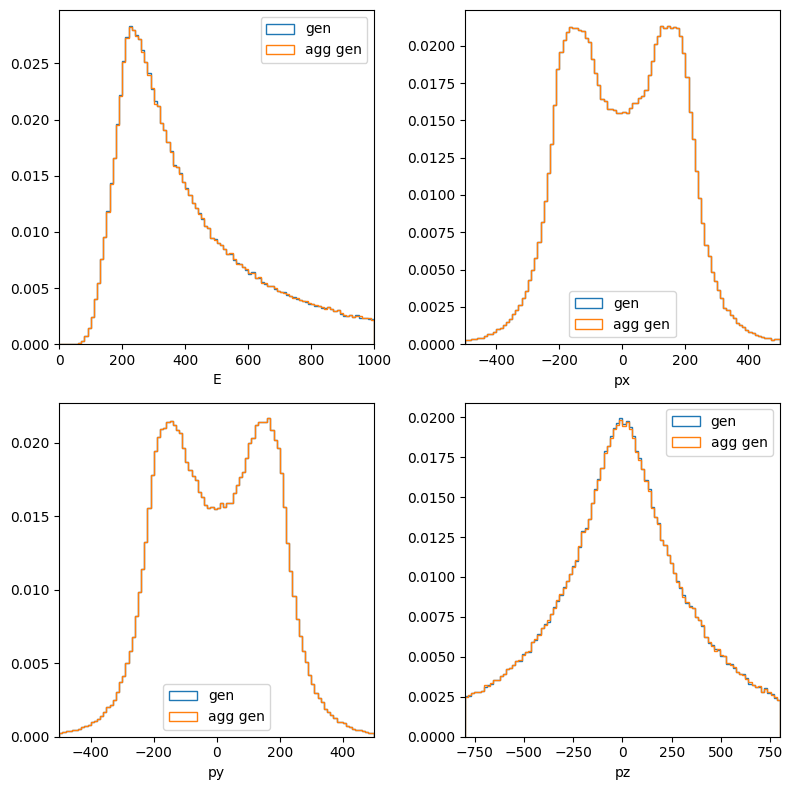

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
labels = ['E', 'px', 'py', 'pz']
x_limits = [(0, 1000), (-500,500), (-500,500), (-800,800)]
for i, ax in enumerate(ax.flatten()):
    gen_hist, bins = np.histogram(gen_jets_fourmomenta[:, i], bins=100, range=x_limits[i])
    agg_gen_hist, _ = np.histogram(agg_gen_fourmomenta[:, i], bins=bins)
    det_hist, _ = np.histogram(det_jets_fourmomenta[:, i], bins=bins)
    agg_det_hist, _ = np.histogram(agg_det_fourmomenta[:, i], bins=bins)
    
    gen_hist = gen_hist / len(gen_jets_fourmomenta)
    agg_gen_hist = agg_gen_hist / len(agg_gen_fourmomenta)
    det_hist = det_hist / len(det_jets_fourmomenta)
    agg_det_hist = agg_det_hist / len(agg_det_fourmomenta)
    
    ax.hist(bins[:-1], bins=bins, weights=gen_hist, label='gen', histtype='step')
    ax.hist(bins[:-1], bins=bins, weights=agg_gen_hist, label='agg gen', histtype='step')
    # ax.hist(bins[:-1], bins=bins, weights=det_hist, label='det', histtype='step')
    # ax.hist(bins[:-1], bins=bins, weights=agg_det_hist, label='agg det', histtype='step')
    ax.set_xlabel(labels[i])
    ax.set_xlim(x_limits[i])
    
    ax.legend()
fig.tight_layout()
plt.show()

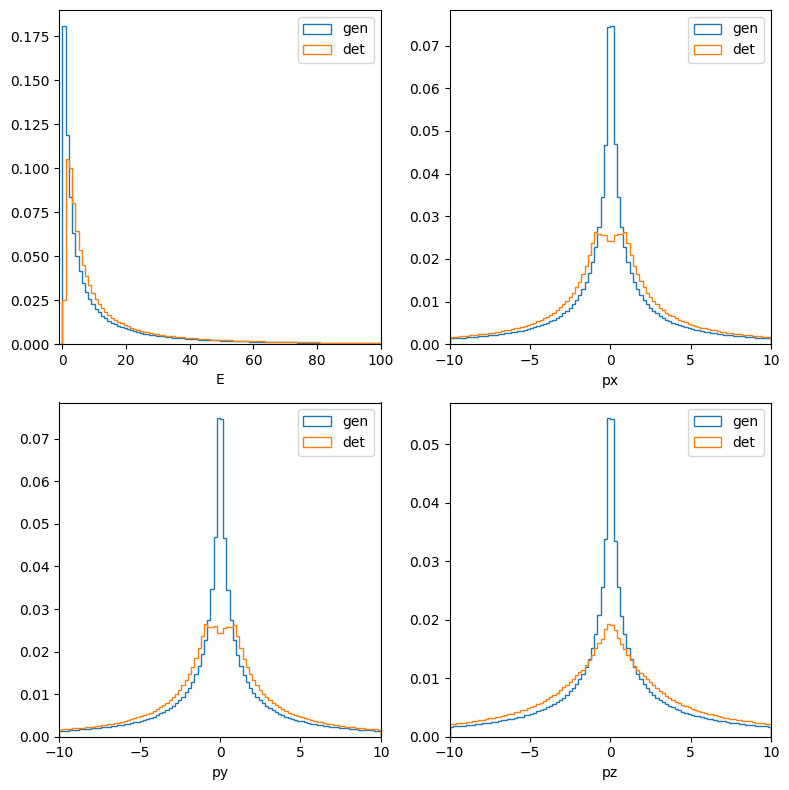

In [30]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
labels = ['E', 'px', 'py', 'pz']
x_limits = [(-1, 100), (-10, 10), (-10, 10), (-10, 10)]
for i, ax in enumerate(ax.flatten()):
    gen_hist, bins = np.histogram(gen_fourmomenta[:, i], bins=100, range=x_limits[i])
    det_hist, _ = np.histogram(det_fourmomenta[:, i], bins=bins)
    
    gen_hist = gen_hist / len(gen_fourmomenta)
    det_hist = det_hist / len(det_fourmomenta)
    
    ax.hist(bins[:-1], bins=bins, weights=gen_hist, label='gen', histtype='step')
    ax.hist(bins[:-1], bins=bins, weights=det_hist, label='det', histtype='step')
    ax.set_xlabel(labels[i])
    ax.set_xlim(x_limits[i])
    
    ax.legend()
fig.tight_layout()
plt.show()

In [18]:
n = 2

In [19]:
det_pt_mask = nth_largest_pt_mask(det_particles, n)
gen_pt_mask = nth_largest_pt_mask(gen_particles, n)

In [20]:
det_first_particles = jetmomenta_to_fourmomenta(det_particles[det_pt_mask])
gen_first_particles = jetmomenta_to_fourmomenta(gen_particles[gen_pt_mask])

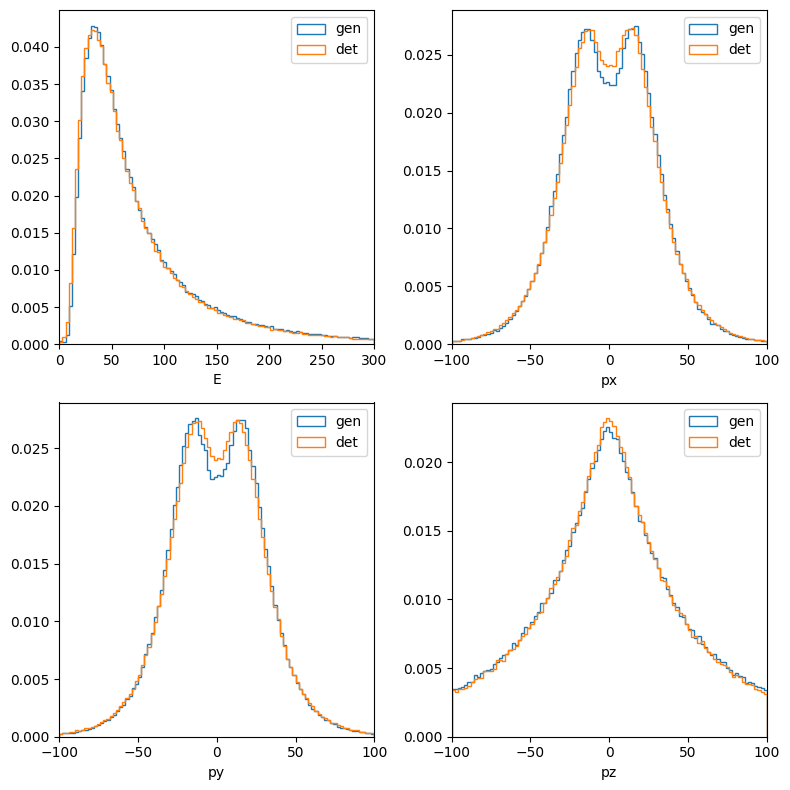

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
labels = ['E', 'px', 'py', 'pz']
x_limits = [(0, 300), (-100, 100), (-100, 100), (-100, 100)]
for i, ax in enumerate(ax.flatten()):
    gen_hist, bins = np.histogram(gen_first_particles[:, i], bins=100, range=x_limits[i])
    det_hist, _ = np.histogram(det_first_particles[:, i], bins=bins)
    
    gen_hist = gen_hist / np.sum(gen_hist)
    det_hist = det_hist / np.sum(det_hist)
    
    ax.hist(bins[:-1], bins=bins, weights=gen_hist, label='gen', histtype='step')
    ax.hist(bins[:-1], bins=bins, weights=det_hist, label='det', histtype='step')
    ax.set_xlabel(labels[i])
    ax.set_xlim(x_limits[i])
    
    ax.legend()
fig.tight_layout()
plt.show()

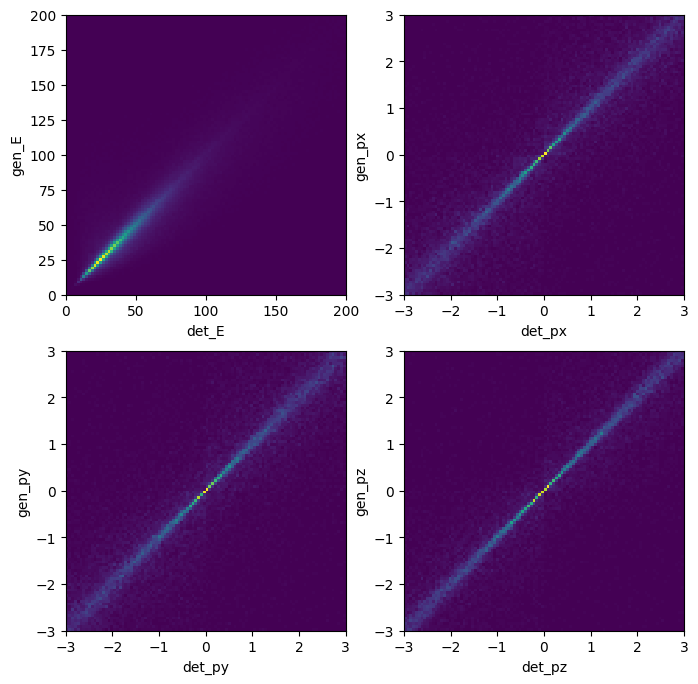

In [22]:
ig, ax = plt.subplots(2, 2, figsize=(8, 8))
labels = ['E', 'px', 'py', 'pz']
ax_limits = [(0, 200), (-3,3), (-3, 3), (-3, 3)]
for i, ax in enumerate(ax.flatten()):
    ax.hist2d(det_first_particles[:, i], gen_first_particles[:, i], bins=100, range = (ax_limits[i], ax_limits[i]))
    ax.set_xlabel('det_'+labels[i])
    ax.set_ylabel('gen_'+labels[i])
    ax.set_aspect('equal')
    ax.set_xlim(ax_limits[i])
    ax.set_ylim(ax_limits[i])
fig.tight_layout()
plt.show()